# Imports and Functions

In [30]:
import numpy as np
import pandas as pd

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score, recall_score, precision_score, accuracy_score

from boruta import BorutaPy
import shap

import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
def make_target(row):
   if (row['Bullied_on_school_property_in_past_12_months'] == 'Yes' or row['Bullied_not_on_school_property_in_past_12_months'] == 'Yes' or row['Cyber_bullied_in_past_12_months'] == 'Yes'):
      return 1
   return 0

# Data Cleaning

In [2]:
df = pd.read_csv('../data/Bullying_2018.csv', delimiter=';')
df.drop('record', axis=1, inplace=True)
df.head()

,Bullied_on_school_property_in_past_12_months,Bullied_not_on_school_property_in_past_12_months,Cyber_bullied_in_past_12_months,Custom_Age,Sex,Physically_attacked,Physical_fighting,Felt_lonely,Close_friends,Miss_school_no_permission,Other_students_kind_and_helpful,Parents_understand_problems,Most_of_the_time_or_always_felt_lonely,Missed_classes_or_school_without_permission,Were_underweight,Were_overweight,Were_obese
0,Yes,Yes,,13 years old,Female,0 times,0 times,Always,2,10 or more days,Never,Always,Yes,Yes,,,
1,No,No,No,13 years old,Female,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,,,
2,No,No,No,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No
3,No,No,No,16 years old,Male,0 times,2 or 3 times,Never,3 or more,0 days,Sometimes,,No,No,No,No,No
4,No,No,No,13 years old,Female,0 times,0 times,Rarely,3 or more,0 days,Most of the time,Most of the time,No,No,,,


In [3]:
# To simplify our analysis, we may just drop the missing rows
# However, there are columns with empty strings. So, we may first replace this values with nan
df.replace({' ':np.nan}, inplace=True)
df.dropna(inplace=True)
df.head()

,Bullied_on_school_property_in_past_12_months,Bullied_not_on_school_property_in_past_12_months,Cyber_bullied_in_past_12_months,Custom_Age,Sex,Physically_attacked,Physical_fighting,Felt_lonely,Close_friends,Miss_school_no_permission,Other_students_kind_and_helpful,Parents_understand_problems,Most_of_the_time_or_always_felt_lonely,Missed_classes_or_school_without_permission,Were_underweight,Were_overweight,Were_obese
2,No,No,No,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No
5,No,No,No,13 years old,Male,0 times,1 time,Never,3 or more,0 days,Most of the time,Always,No,No,No,No,No
10,No,No,No,15 years old,Male,0 times,1 time,Never,3 or more,3 to 5 days,Most of the time,Always,No,Yes,No,No,No
22,No,No,Yes,13 years old,Male,0 times,2 or 3 times,Most of the time,3 or more,0 days,Rarely,Always,Yes,No,No,No,No
23,No,No,No,14 years old,Male,0 times,2 or 3 times,Most of the time,2,0 days,Always,Sometimes,Yes,No,No,Yes,Yes


In [10]:
# Creating our target variable
df['target'] = df.apply(lambda row: make_target(row), axis=1)
df.head()

,Bullied_on_school_property_in_past_12_months,Bullied_not_on_school_property_in_past_12_months,Cyber_bullied_in_past_12_months,Custom_Age,Sex,Physically_attacked,Physical_fighting,Felt_lonely,Close_friends,Miss_school_no_permission,Other_students_kind_and_helpful,Parents_understand_problems,Most_of_the_time_or_always_felt_lonely,Missed_classes_or_school_without_permission,Were_underweight,Were_overweight,Were_obese,target
2,No,No,No,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No,0
5,No,No,No,13 years old,Male,0 times,1 time,Never,3 or more,0 days,Most of the time,Always,No,No,No,No,No,0
10,No,No,No,15 years old,Male,0 times,1 time,Never,3 or more,3 to 5 days,Most of the time,Always,No,Yes,No,No,No,0
22,No,No,Yes,13 years old,Male,0 times,2 or 3 times,Most of the time,3 or more,0 days,Rarely,Always,Yes,No,No,No,No,1
23,No,No,No,14 years old,Male,0 times,2 or 3 times,Most of the time,2,0 days,Always,Sometimes,Yes,No,No,Yes,Yes,0


In [13]:
df.target.value_counts(normalize=True)

0    0.59363
1    0.40637
Name: target, dtype: float64

In [14]:
# Dropping the bullying features
df.drop(['Bullied_on_school_property_in_past_12_months', 'Bullied_not_on_school_property_in_past_12_months', 'Cyber_bullied_in_past_12_months'],
        axis=1,
        inplace=True)
df.head()

,Custom_Age,Sex,Physically_attacked,Physical_fighting,Felt_lonely,Close_friends,Miss_school_no_permission,Other_students_kind_and_helpful,Parents_understand_problems,Most_of_the_time_or_always_felt_lonely,Missed_classes_or_school_without_permission,Were_underweight,Were_overweight,Were_obese,target
2,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No,0
5,13 years old,Male,0 times,1 time,Never,3 or more,0 days,Most of the time,Always,No,No,No,No,No,0
10,15 years old,Male,0 times,1 time,Never,3 or more,3 to 5 days,Most of the time,Always,No,Yes,No,No,No,0
22,13 years old,Male,0 times,2 or 3 times,Most of the time,3 or more,0 days,Rarely,Always,Yes,No,No,No,No,1
23,14 years old,Male,0 times,2 or 3 times,Most of the time,2,0 days,Always,Sometimes,Yes,No,No,Yes,Yes,0


In [15]:
# Checking if there are missing values
df.isna().sum()

Custom_Age                                     0
Sex                                            0
Physically_attacked                            0
Physical_fighting                              0
Felt_lonely                                    0
Close_friends                                  0
Miss_school_no_permission                      0
Other_students_kind_and_helpful                0
Parents_understand_problems                    0
Most_of_the_time_or_always_felt_lonely         0
Missed_classes_or_school_without_permission    0
Were_underweight                               0
Were_overweight                                0
Were_obese                                     0
target                                         0
dtype: int64

# Model Development

In [18]:
# Setting the columns to ordinal or categorical
# Here, categorical columns with a sense of order (age, number of times that something hapenned) were set to ordinal

categorical_columns = [
    'Sex',
    'Felt_lonely',
    'Other_students_kind_and_helpful',
    'Parents_understand_problems',
    'Most_of_the_time_or_always_felt_lonely',
    'Missed_classes_or_school_without_permission',
    'Were_underweight',
    'Were_overweight',
    'Were_obese'
]

ordinal_columns = [
    'Custom_Age',
    'Physically_attacked',
    'Physical_fighting',
    'Close_friends',
    'Miss_school_no_permission'
]

In [19]:
# Creating the mapping order to ordinal columns

ordinal_cols_mapping = [
    ['11 years old or younger', '12 years old', '13 years old', '14 years old', '15 years old', '16 years old', '17 years old', '18 years old or older'],
    ['0 times', '1 time', '2 or 3 times', '4 or 5 times', '6 or 7 times', '8 or 9 times', '10 or 11 times', '12 or more times'],
    ['0 times', '1 time', '2 or 3 times', '4 or 5 times', '6 or 7 times', '8 or 9 times', '10 or 11 times', '12 or more times'],
    ['0', '1', '2', '3 or more'],
    ['0 days', '1 or 2 days', '3 to 5 days', '6 to 9 days', '10 or more days']
]

In [20]:
# Constructing the preprocessing pipeline

categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
    ]
)

ordinal_transformer = Pipeline(
    steps=[
        ('encoder', OrdinalEncoder(categories=ordinal_cols_mapping, handle_unknown='use_encoded_value', unknown_value=-1))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
        ('ord', ordinal_transformer, ordinal_columns)
    ]
)

In [48]:
# Defining the model pipeline

model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    class_weight='balanced',
    n_jobs=-1,
    verbose=True
)

model_pipeline_rf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('rf', model_rf)
    ]
)

# With this set_output API we are able to track the feature names which the pipeline outputs
model_pipeline_rf.set_output(transform='pandas')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Felt_lonely',
                                                   'Other_students_kind_and_helpful',
                                                   'Parents_understand_problems',
                                                   'Most_of_the_time_or_always_felt_lonely',
                                                   'Missed_classes_or_school_without_permission',
                                                   'Were...
                                                                                               'to '
                                                                                               '5 '
                                                                                               'days',
                                                                                               '6 '
                                                                                               'to '
                                                                                               '9 '
                                                                                               'days',
                                                                                               '10 '
                                                                                               'or '
                                                                                               'more '
                                                                                               'days']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Custom_Age',
                                                   'Physically_attacked',
                                                   'Physical_fighting',
                                                   'Close_friends',
                                                   'Miss_school_no_permission'])])),
                ('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=200, n_jobs=-1,
                                        verbose=True))])

In [94]:
# Train/test split

X = df.drop('target', axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.3,
    random_state=123
)

In [95]:
# Fitting the model

model_pipeline_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Felt_lonely',
                                                   'Other_students_kind_and_helpful',
                                                   'Parents_understand_problems',
                                                   'Most_of_the_time_or_always_felt_lonely',
                                                   'Missed_classes_or_school_without_permission',
                                                   'Were...
                                                                                               'to '
                                                                                               '5 '
                                                                                               'days',
                                                                                               '6 '
                                                                                               'to '
                                                                                               '9 '
                                                                                               'days',
                                                                                               '10 '
                                                                                               'or '
                                                                                               'more '
                                                                                               'days']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Custom_Age',
                                                   'Physically_attacked',
                                                   'Physical_fighting',
                                                   'Close_friends',
                                                   'Miss_school_no_permission'])])),
                ('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=200, n_jobs=-1,
                                        verbose=True))])

# Model Evaluation

In [96]:
y_pred = model_pipeline_rf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [97]:
print('Accuracy score:', recall_score(y_test, y_pred))
print('Recall score:', recall_score(y_test, y_pred, average='macro'))
print('Precision score:', precision_score(y_test, y_pred, average='macro'))
print('AUC score:', roc_auc_score(y_test, y_pred))

Accuracy score: 0.6364541832669323
Recall score: 0.6467303306378984
Precision score: 0.6423993522051588
AUC score: 0.6467303306378985


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


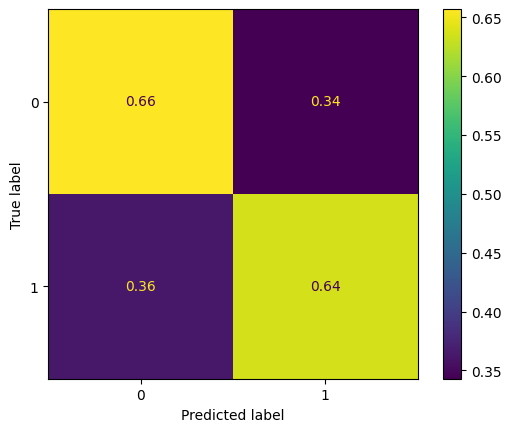

In [98]:
disp = ConfusionMatrixDisplay.from_estimator(estimator=model_pipeline_rf,
                                             X=X_test,
                                             y=y_test,
                                             normalize='true')

# Feature Importance

Text(0.5, 0, 'Relative Importance')

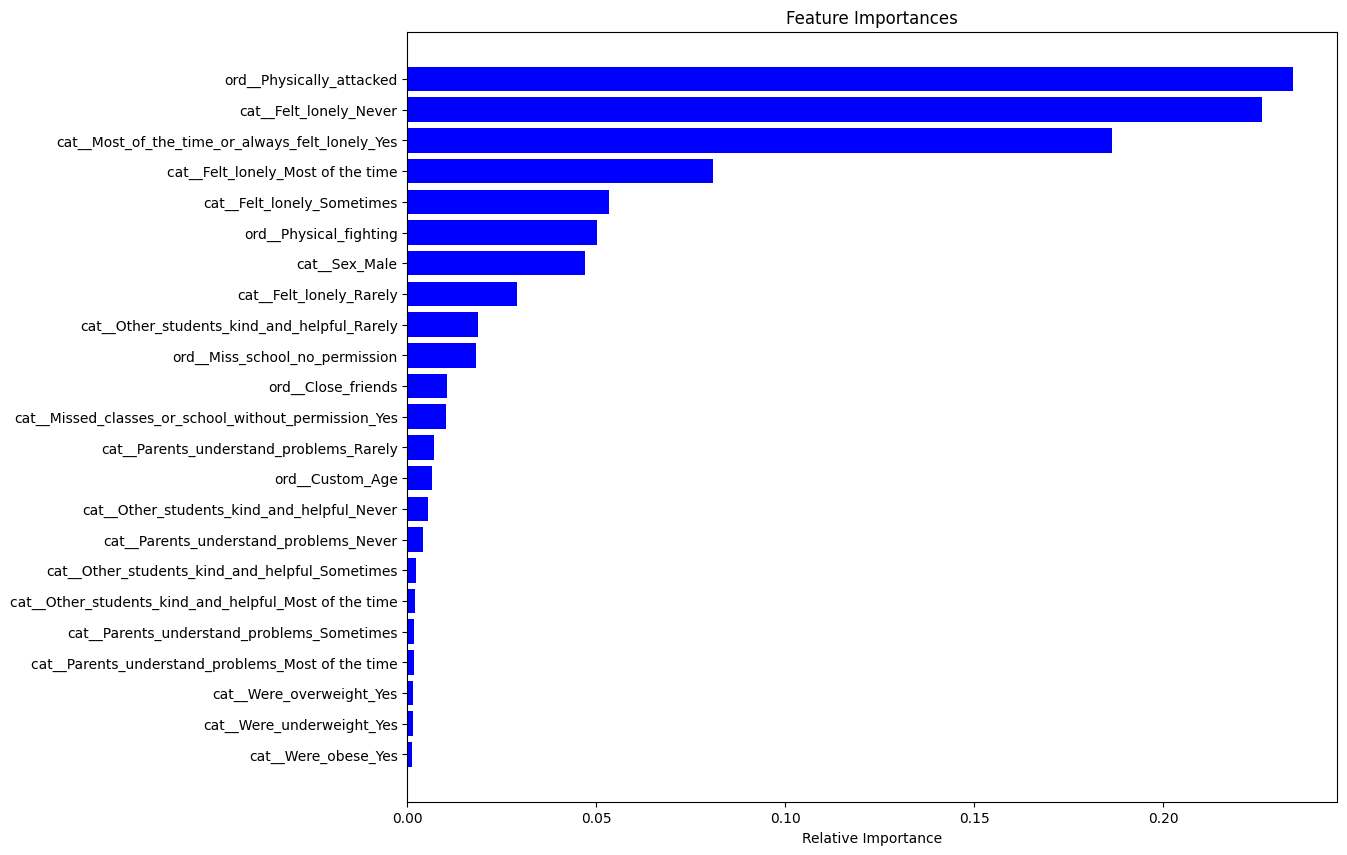

In [106]:
features = model_pipeline_rf['rf'].feature_names_in_
importances = model_pipeline_rf['rf'].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

Seems like Phisically attacked was the main predictor to tell if someone will suffer from bullying. However, there are a lot of features here to observe. Let's see if we may run some feature selection

# Model Training with Feature Selection (Boruta)

In [107]:
# Creating DataFrame for categorical test and train
X_train_cat = X_train[categorical_columns]
X_test_cat = X_test[categorical_columns]

# Creating DataFrame for ordinal test and train
X_train_ord = X_train[ordinal_columns]
X_test_ord = X_test[ordinal_columns]

In [108]:
# Encoding the categorical columns

ohe = OneHotEncoder(handle_unknown='ignore', drop='first')
X_train_ohe = ohe.fit_transform(X_train_cat)
X_test_ohe = ohe.transform(X_test_cat)

In [109]:
columns = ohe.get_feature_names_out(input_features=X_train_cat.columns)
X_train_processed_ohe = pd.DataFrame(X_train_ohe.todense(), columns=columns)
X_test_processed_ohe = pd.DataFrame(X_test_ohe.todense(), columns=columns)

In [110]:
# Encoding the ordinal columns

ore = OrdinalEncoder(categories=ordinal_cols_mapping, handle_unknown='use_encoded_value', unknown_value=-1)
X_train_ore = ore.fit_transform(X_train_ord)
X_test_ore = ore.fit_transform(X_test_ord)

In [111]:
columns = ore.get_feature_names_out()
X_train_processed_ore = pd.DataFrame(X_train_ore, columns=columns)
X_test_processed_ore = pd.DataFrame(X_test_ore, columns=columns)

In [112]:
# Concatenating the processed dataframes

X_train_boruta = pd.concat([X_train_processed_ohe, X_train_processed_ore], axis=1)
X_test_boruta = pd.concat([X_test_processed_ohe, X_test_processed_ore], axis=1)

X_train_boruta.head()

,Sex_Male,Felt_lonely_Most of the time,Felt_lonely_Never,Felt_lonely_Rarely,Felt_lonely_Sometimes,Other_students_kind_and_helpful_Most of the time,Other_students_kind_and_helpful_Never,Other_students_kind_and_helpful_Rarely,Other_students_kind_and_helpful_Sometimes,Parents_understand_problems_Most of the time,...,Most_of_the_time_or_always_felt_lonely_Yes,Missed_classes_or_school_without_permission_Yes,Were_underweight_Yes,Were_overweight_Yes,Were_obese_Yes,Custom_Age,Physically_attacked,Physical_fighting,Close_friends,Miss_school_no_permission
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,3.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,2.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,3.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,3.0,0.0


In [114]:
# Defining the selector object with Boruta

feat_selector = BorutaPy(model_rf, n_estimators='auto', verbose=2, random_state=42)

In [115]:
feat_selector.fit(X_train_boruta.values, y_train.values)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    0.7s finished


Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


Iteration: 	8 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	6


[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


Iteration: 	9 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	6


[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Iteration: 	10 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	6


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Iteration: 	11 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	6


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Iteration: 	12 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	6


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


Iteration: 	13 / 100
Confirmed: 	16
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	14 / 100
Confirmed: 	16
Tentative: 	0
Rejected: 	7


[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    0.5s finished


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=116, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x21400A27A40,
                                          verbose=True),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x21400A27A40, verbose=2)

In [116]:
# Print accepted features as well as features that boruta did not ###deem unimportant or important (area of irresolution)
accept = X_train_boruta.columns[feat_selector.support_].to_list()
irresolution = X_train_boruta.columns[feat_selector.support_weak_].to_list()
print('Accepted features:')
print(list(accept))
print('Irresolution features:')
print(list(irresolution))

Accepted features:
['Sex_Male', 'Felt_lonely_Most of the time', 'Felt_lonely_Never', 'Felt_lonely_Rarely', 'Felt_lonely_Sometimes', 'Other_students_kind_and_helpful_Never', 'Other_students_kind_and_helpful_Rarely', 'Parents_understand_problems_Never', 'Parents_understand_problems_Rarely', 'Most_of_the_time_or_always_felt_lonely_Yes', 'Missed_classes_or_school_without_permission_Yes', 'Custom_Age', 'Physically_attacked', 'Physical_fighting', 'Close_friends', 'Miss_school_no_permission']
Irresolution features:
[]


In [117]:
model_rf_boruta = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    class_weight='balanced',
    n_jobs=-1,
    verbose=True
)

In [118]:
# Training a model with just accepted features from Boruta

model_rf_boruta.fit(X_train_boruta[list(accept)], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished


RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200,
                       n_jobs=-1, verbose=True)

In [119]:
y_pred_boruta = model_rf_boruta.predict(X_test_boruta[list(accept)])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [120]:
print('Accuracy score:', recall_score(y_test, y_pred_boruta))
print('Recall score:', recall_score(y_test, y_pred_boruta, average='macro'))
print('Precision score:', precision_score(y_test, y_pred_boruta, average='macro'))
print('AUC score:', roc_auc_score(y_test, y_pred_boruta))

Accuracy score: 0.640687250996016
Recall score: 0.6472273622862794
Precision score: 0.6427314222372492
AUC score: 0.6472273622862794


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


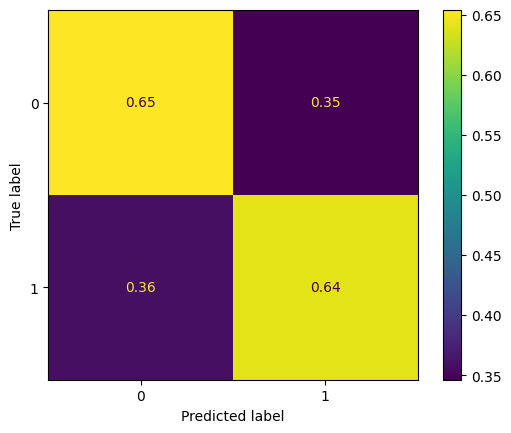

In [121]:
disp = ConfusionMatrixDisplay.from_estimator(estimator=model_rf_boruta,
                                             X=X_test_boruta[list(accept)],
                                             y=y_test,
                                             normalize='true')

Great! We were able to achieve the same metrics with less variables!

Text(0.5, 0, 'Relative Importance')

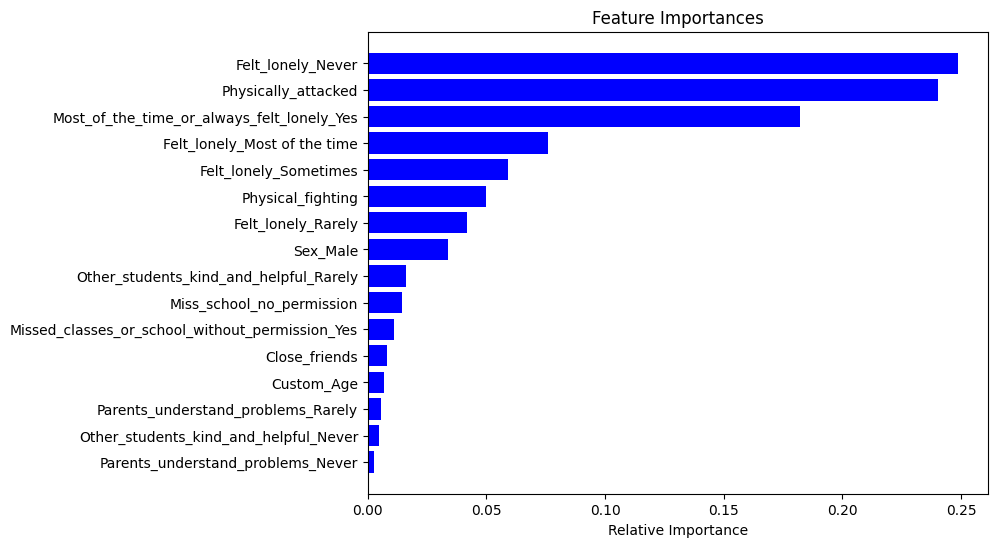

In [122]:
features = model_rf_boruta.feature_names_in_
importances = model_rf_boruta.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')